# A Guide to Using `TorchFit`

`TorchFit` is a bare-bones, minimalistic, **training-helper for PyTorch** that exposes an easy-to-use `fit` method in the style of **fastai** and **Keras**.  It is intended to be easy-to-apply with a tiny footprint and as little bloat as possible, which makes it particularly well-suited to those new to PyTorch looking to train classifiers.   

*For more complex training scnenarios (e.g., training GANs, multi-node GPU training), [PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning) is highly recommended.*

The model and dataset used in this tutorial are taken directly from the [PyTorch Text Classification Tutorial](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html).

Let's begin by importing some standard Torch and Python modules:

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# torch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

# torchtext for preprocessing
import torchtext
from torchtext.datasets import text_classification

Next, import `TorchFit`:

In [2]:
import torchfit

## Define Your Data and Model Normally in PyTorch

We will begin by constructing data loaders for the training, validation, and test sets and defining a model just as one would normally do when using **PyTorch**. 

We use a text classification model based on an `EmbeddingBag` layer and the AG_NEWS dataset - both of which were used in the [PyTorch Text Classification Tutorial](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html).

By default, `TorchFit` can be directly used with any model accepting either a single input Tensor or a list of input Tensors.  For these reasons, we have configured `generate_batch` to generate tuples in the form `([text, offsets], label)` instead of `(text, offsets, label)`. 

*(To handle alternative data formats and other non-standard steps (e.g., loss computations), one can easily subclass `torchfit.Learner` and override a small number of methods to satisfy such non-standard training scenarios.  We show an example of this at the end of this notebook.)*

In [3]:
# The code in this cell is from the PyTorch tutorials:
#   https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

# DATALOADERS
NGRAMS = 2
import os
if not os.path.isdir('./.data'):
	os.mkdir('./.data')
train_dataset, test_dataset = text_classification.DATASETS['AG_NEWS'](
    root='./.data', ngrams=NGRAMS, vocab=None)
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return [text, offsets], label

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])
train_loader = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=generate_batch)
val_loader = DataLoader(sub_valid_, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=generate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=generate_batch)

# MODEL
class MyTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, data):
        text = data[0]
        offsets = data[1]
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)
    
VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 32
NUN_CLASS = len(train_dataset.get_labels())
model = MyTextClassifier(VOCAB_SIZE, EMBED_DIM, NUN_CLASS)

# OPTIMIZER, LOSS FUNCTION, and METRICS
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
criterion = torch.nn.CrossEntropyLoss()
import numpy as np
def accuracy(y_true, y_pred):
    return np.mean(y_true.numpy() == np.argmax(y_pred.numpy(), axis=1))

120000lines [00:08, 14984.76lines/s]
120000lines [00:16, 7213.03lines/s]
7600lines [00:01, 7419.70lines/s]


## Wrap Model and Data in  `torchfit.Learner`

Having constructed our model and data loaders, we will wrap everything in a `torchfit.Learner` object to help us train the model.

In [4]:
import torchfit
learner = torchfit.Learner(model, train_loader, val_loader=val_loader, 
                           optimizer=optimizer, loss=criterion, device=device)

## Estimate Learning Rate

We can use the `find_lr` method to estimate a good learning rate for training given our data and model.
This will generate a plot from which we can select a learning rate associated with a falling loss. We choose to set the `start_lr` and `end_lr` relatively higher than the default because the `SGD` optimizer tends to have higher learning rates than others like `Adam`. We also run `find_lr` for a larger number of iterations (i.e., 1500) to obtain a more accurate estimate of the maximum learning rate we can use for this problem.

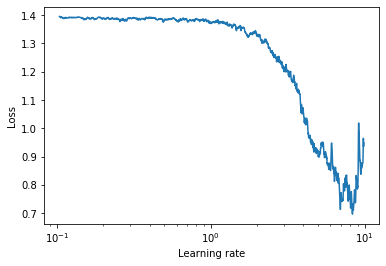

From the plot, select the highest learning rate still associated with a falling loss.


In [5]:
learner.find_lr(start_lr=0.1, end_lr=10, num_iter=1500)

Based on the plot, we will use a learning rate of `4.0`.

## Train the Model

We will train using the `fit_onecycle` method, which employs a [slanted triangle learning rate policy (STLR)](https://arxiv.org/abs/1801.06146) proposed by Howard and Ruder (2018). STLR is a variation on the [1cycle policy](https://arxiv.org/pdf/1803.09820.pdf) proposed by Leslie Smith, which has been shown to be exceedingly effective across a variety of models and datasets.

In [6]:
lr = 4.0

In [7]:
learner.fit_onecycle(lr, 3)

Epoch 1 / 3
[========================================] 100%	  loss: 0.6565  accuracy: 0.9242  val_loss: 0.3245  val_accuracy: 0.8923

Epoch 2 / 3
[========================================] 100%	  loss: 0.2260  accuracy: 0.9610  val_loss: 0.2812  val_accuracy: 0.9082

Epoch 3 / 3
[========================================] 100%	  loss: 0.1255  accuracy: 0.9737  val_loss: 0.2773  val_accuracy: 0.9118



With 3 epochs, we are at a **91%** accuracy. Let's plot the training vs. validation loss and also examine a plot of the learning rate schedule we employed.

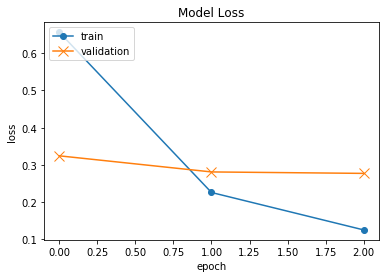

In [8]:
learner.plot('loss')

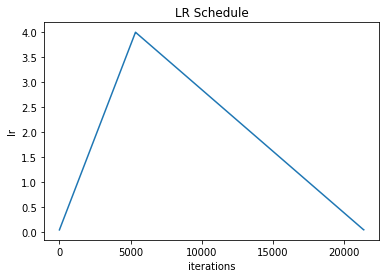

In [9]:
learner.plot('lr')

The `fit_onecycle` method includes a `start_pct` parameter that controls the degree of the slant.  At `start_pct=0.5`, this reduces to a classical 1cycle policy.  

In addition, user-configured learning rate schedules can also be used. For instance, one can train with a manually-configured slanted triangle learning rate schedule as follows:


```python
epochs=3
scheduler = torch.optim.lr_scheduler.CyclicLR(learner.optimizer, 
                                             base_lr=lr/10, 
                                             max_lr=lr, 
                                             cycle_momentum=False, 
                                             step_size_up=epochs*len(train_loader)//3,
                                             step_size_down=epochs*2*len(train_loader)//3)
hist = learner.fit(lr, epochs, schedulers=[scheduler])
```

Note that, when explicitly suppying user-configured learning rate scheduler to `learner.fit`, the the `lr` parameter to `fit` is ignored and the learning rate setting in the optimizer and/or scheduler is used instead (`max_lr` in the example above).

## Making Predictions

Let's make predictions on the test set.  The `learner.predict` method returns a NumPy array of the predictions
and optionally the ground truth targets, as well.

In [10]:
outputs, targets = learner.predict(test_loader, return_targets=True)

In [11]:
print('test accuracy is: %s' % ((np.mean(targets == np.argmax(outputs, axis=-1)))))

test accuracy is: 0.9090789473684211


Next, let's make predictions on random raw data that we generate.  To do so, we will create a custom `prepreprocess` function that will transform the raw data into the form expected by our model. 

We can then use the `predict_example` method to generate predictions from raw data.

In [12]:
# A prepreprocess function for our problem

import re
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer
vocab = train_dataset.get_vocab()

labels = ['World', 'Sports', 'Business', 'Sci/Tech']

def preprocess(text):
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([vocab[token]
                            for token in ngrams_iterator(tokenizer(text), 2)])
        return [text, torch.tensor([0])]

In [13]:
text = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

learner.predict_example(text, preproc_fn=preprocess, labels=labels)

'Sports'

In [14]:
text = 'The stock price of IBM shot up today after its earnings report.'
learner.predict_example(text, preproc_fn=preprocess, labels=labels)

'Business'

In [15]:
text = 'Iran continues its nuclear development despite sanctions by the United Nations.'
learner.predict_example(text, preproc_fn=preprocess, labels=labels)

'World'

## Saving and Restoring Models

We can save our model to disk and reload it later in deployment.

In [16]:
learner.save('/tmp/mymodel')

In [17]:
learner.load('/tmp/mymodel')

In [18]:
outputs = np.argmax(learner.predict(test_loader), axis=-1)
labels = [label for data, label in test_loader]
print('test accuracy is: %s' % ((np.mean(targets == outputs))))

test accuracy is: 0.9090789473684211


## Using `TorchFit` in Non-Standard Training Scenarios

The standard boilerplate code for training is typically:

```python
inputs, target = batch[0], batch[1] # extract data from batch
outputs = model(inputs)             # forward pass
loss = criterion(outputs, targets)  # compute loss
loss.backward()                     # backward pass
optimizer.step()                    # optimize
```
Some situations diverge from this standard template. Suppose, for instance, we want to manually add regularization to our loss as follows:
```python
loss = self.criterion(output, targets)
reg_loss = 0
for param in self.parameters():
    reg_loss += 0.001 * torch.sum(param * param)
loss = loss + reg_loss
```

Such custom steps in training can be handled in `TorchFit` by subclassing the `torchfit.Learner` class and overriding at most five methods: `forward`, `compute_loss`, `train_step`, `validation_step`, `test_step`.  To illustrate this, let's re-implement the model above with one change.  We will configure the model to accept exactly two inputs for the `EmbeddingBag` layer:  `text` and `offsets` instead of a single list of inputs (see the `forward` method and the `generate_batch` function below).

In [19]:
# DATALOADERS
NGRAMS = 2
import os
if not os.path.isdir('./.data'):
	os.mkdir('./.data')
train_dataset, test_dataset = text_classification.DATASETS['AG_NEWS'](
    root='./.data', ngrams=NGRAMS, vocab=None)
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])
train_loader = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=generate_batch)
val_loader = DataLoader(sub_valid_, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=generate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=generate_batch)

# MODEL
class MyTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)
    
VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 32
NUN_CLASS = len(train_dataset.get_labels())
model = MyTextClassifier(VOCAB_SIZE, EMBED_DIM, NUN_CLASS)

# OPTIMIZER, LOSS FUNCTION, and METRICS
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
criterion = torch.nn.CrossEntropyLoss()
import numpy as np
def accuracy(y_true, y_pred):
    return np.mean(y_true.numpy() == np.argmax(y_pred.numpy(), axis=1))

120000lines [00:07, 15092.02lines/s]
120000lines [00:16, 7141.90lines/s]
7600lines [00:01, 7241.05lines/s]


#### Subclassing `torchfit.Learner`

Next, we will subclass `torchfit.Learner` and override at most five methods to handle custom scenarios.  For this problem, we only really need to override `forward` and `train_step`, but we override all five methods for illustration purposes.

In [20]:
class CustomLearner(torchfit.Learner):
    def forward(self, text, offsets):
        """
        Needs to be overridden since EmbeddingBag
        model is expecting text and offsets in as 
        separate parameters
        """
        return self.model(text, offsets)


    def train_step(self, batch, batch_idx):
        """
        Needs to be overridden since batches
        are in a form specific to EmbeddingBag layer
        """
        text, offsets, label = batch
        text = text.to(device)
        offsets = offsets.to(device)
        label = label.to(device)
        outputs = self.forward(text, offsets)

        # compute loss
        batch_loss = self.compute_loss(outputs, label)
        return {'loss': batch_loss, 'targets':label, 'outputs': outputs}

    def compute_loss(self, outputs, targets):
        """Not required to be overriden for this particular problem"""
        return self.loss(outputs, targets)

    def validation_step(self, batch, batch_idx):
        """Not required to be overrident of this particular problem"""
        return self.train_step(batch, batch_idx)
    
    def validation_step(self, batch, batch_idx):
        """Not required to be overrident for this particular problem"""
        return self.train_step(batch, batch_idx)

In [21]:
learner = CustomLearner(model, train_loader, val_loader=val_loader, 
                        optimizer=optimizer, loss=criterion, device=device)

In [22]:
learner.fit_onecycle(4, 1)

Epoch 1 / 1
[========================================] 100%	  loss: 0.5132  accuracy: 0.9274  val_loss: 0.3027  val_accuracy: 0.9028



### Additional Features

`TorchFit` also includes support for many other features:

#### Resetting the Model
The weights of the neural network model can be easily reset using `learner.reset_weights()`. 


#### Gradient Accumulation
```learner.fit_onecycle(lr, 1, accumulation_steps=8)```

#### Gradient Clipping
```learner.fit_onecycle(lr, 1, gradient_clip_val=1)```


#### Mixed Precision Training
```torchfit.Learner(model, train_loader, val_loader=val_loader, use_amp=True, amp_level='O2')```

#### Multi-GPU Training and GPU Selection

To train on first two GPUs (0 and 1):

```learner = torchfit.Learner(model, train_loader, val_loader=test_loader, gpus=[0,1])```

To train only on the second GPU, one can do either this:

```learner = torchfit.Learner(model, train_loader, val_loader=test_loader, gpus=[1])```

or this...

```learner = torchfit.Learner(model, train_loader, val_loader=test_loader, device='cuda:1')```